# ROB317 - Vision 3D
# TP1 : Homographies

**Objectif:** Travailler sur l'estimation d'homographie entre deux images à l'aide de la bibliothèque OpenCV sous Python.

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

print("Version d'OpenCV:", cv2.__version__)

# Path to images
PATH_IMG = './Images_Homographie/'

Version d'OpenCV: 4.10.0


## Q1 : Cas où la transformation est une homographie

**Question:** Dans quels cas la transformation entre deux images est-elle une homographie ?

### Reponse:

A transformation between two images is a homography when the camera undergoes a pure rotation about its optical center (no translation), or when the observed scene is planar and viewed from different poses.

## Q2 : Estimation de l'homographie - Sélection de points

**Question:** À partir du code fourni, essayez d'estimer l'homographie permettant de transformer l'image de la mosaïque `Pompei.jpg` en vue verticale (en supposant le cadre carré). Combien de points au minimum devez-vous sélectionner ?

The minimum amount of points is 4, so that we can solve the Direct Linear Transformation (DLT) system. The four points will give us a exact solution, however if we get more points we'll get inconsistencies due to noise where the system would be re-written as:

$$
A.h = w
$$

where $w \neq 0$. Leading us to estimate the best possible value through: 

$$
\hat{h} = argmin_{h} \bold{w^{t}w}
$$

Using the Singular Value Decomposition method.

### Code pour la sélection de points

**Instructions:**
- Clic gauche : sélectionner un point
- Clic droit : remettre les points à zéro
- Touche 'q' : valider la sélection (minimum 4 points)

Dimension de l'image : 333 lignes x 500 colonnes x 3 couleurs


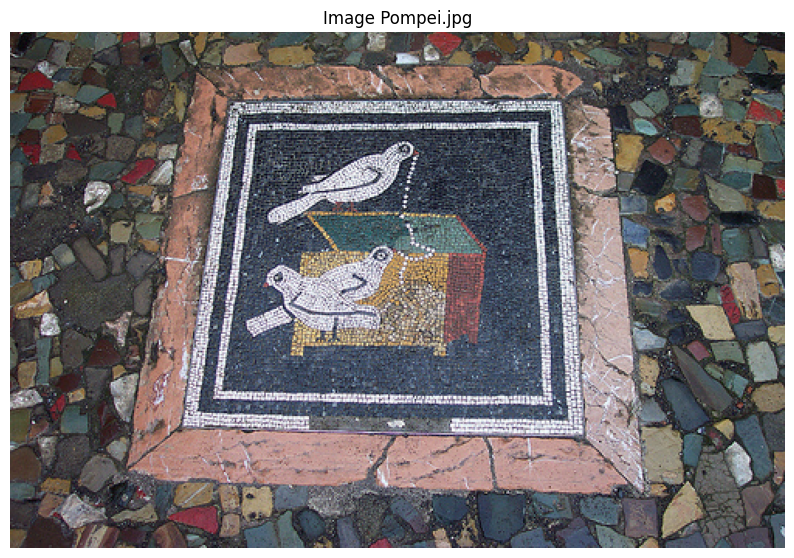

In [3]:
# Chargement de l'image Pompei
img = np.uint8(cv2.imread(PATH_IMG + "Pompei.jpg"))

(h, w, c) = img.shape
print("Dimension de l'image :", h, "lignes x", w, "colonnes x", c, "couleurs")

# Affichage de l'image pour référence
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image Pompei.jpg")
plt.axis('off')
plt.show()

In [4]:
# Fonction de sélection de points avec la souris
def select_points(event, x, y, flags, param):
    global points_selected, X_init
    global img, clone
    if (event == cv2.EVENT_FLAG_LBUTTON):
        x_select, y_select = x, y
        points_selected += 1
        cv2.circle(img, (x_select, y_select), 8, (0, 255, 255), 1)
        cv2.line(img, (x_select-8, y_select), (x_select+8, y_select), (0, 255, 0), 1)
        cv2.line(img, (x_select, y_select-8), (x_select, y_select+8), (0, 255, 0), 1)
        X_init.append([x_select, y_select])
    elif event == cv2.EVENT_FLAG_RBUTTON:
        points_selected = 0
        X_init = []
        img = clone.copy()

# Initialisation
img = np.uint8(cv2.imread(PATH_IMG + "Pompei.jpg"))
clone = img.copy()
points_selected = 0
X_init = []

cv2.namedWindow("Image initiale")
cv2.setMouseCallback("Image initiale", select_points)

while True:
    cv2.imshow("Image initiale", img)
    key = cv2.waitKey(1) & 0xFF
    if (key == ord("q")) & (points_selected >= 4):
        break

cv2.destroyAllWindows()

# Conversion en array numpy
X_init = np.asarray(X_init, dtype=np.float32)
print("Points sélectionnés (X_init) =", X_init)
print("Nombre de points:", len(X_init))

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/lmartim4/Desktop/RO17/.venv/lib64/python3.11/site-packages/cv2/qt/plugins"


Points sélectionnés (X_init) = [[121.  24.]
 [ 75. 287.]
 [410. 302.]
 [380.  24.]]
Nombre de points: 4


In [5]:
X_final = np.zeros((points_selected, 2), np.float32)
for i in range(points_selected):
    string_input = "Correspondant de {} ? ".format(X_init[i])
    X_final[i] = input(string_input).split(" ", 2)

print("Points de destination (X_final) =", X_final)

# This force the selections to be mapped into a square, which works very well to have a top-view

Points de destination (X_final) = [[140.  44.]
 [144. 294.]
 [394. 294.]
 [394.  44.]]


---
## Q3 : Estimation de l'homographie par SVD

**Question:** Pour estimer l'homographie, créez la matrice $2n \times 9$ $A$ comme indiqué en cours à partir de vos $n$ correspondances, puis résolvez le système $Ah = 0$ en utilisant la décomposition en valeurs singulières.

**Rappel de la méthode:**
1. Construire la matrice $A$ (dimension $2n \times 9$)
2. Résoudre $Ah = 0$ avec SVD
3. Normaliser les coordonnées avant, dé-normaliser après

### Questions à répondre:

**a) Quel est l'intérêt de normaliser les coordonnées ?**

The normalisation constrain is usefull because it help the numerical stability of the A martix before the SVD process.

**b) Quel indice de confiance pouvez-vous utiliser pour évaluer la fiabilité du résultat ?**

The best reliability it having the last 2 sigma ratio $\frac{\sigma_8}{\sigma_9}$ large.

### Implémentation de l'estimation d'homographie

In [43]:
def normalize_points(points):
    points = np.array(points, dtype=np.float64)
    
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    distances = np.sqrt(np.sum(centered**2, axis=1))
    mean_dist = np.mean(distances)
    scale = np.sqrt(2) / mean_dist if mean_dist > 0 else 1.0
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ], dtype=np.float64)
    normalized = centered * scale    
    return normalized, T

In [44]:
def build_matrix_A(X_src, X_dst):
    n = len(X_src)
    A = np.zeros((2 * n, 9), dtype=np.float64)
    
    for i in range(n):
        x, y = X_src[i, 0], X_src[i, 1]
        xp, yp = X_dst[i, 0], X_dst[i, 1]
        A[2 * i] = [-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * yp, y * yp, yp]
    
    return A

In [45]:
def estimate_homography(X_src, X_dst):
    X_src = np.array(X_src, dtype=np.float64)
    X_dst = np.array(X_dst, dtype=np.float64)
    
    X_src_norm, T_src = normalize_points(X_src)
    X_dst_norm, T_dst = normalize_points(X_dst)
    
    A = build_matrix_A(X_src_norm, X_dst_norm)
    
    U, S, Vt = np.linalg.svd(A)
    
    h = Vt[-1]
    H_norm = h.reshape(3, 3)
    
    # Step 6: Denormalize: H = T_dst^(-1) @ H_norm @ T_src
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    H = H / H[2, 2]
    
    print(f"{S}")
    
    return H

In [46]:
# Image worked well with this coordinates
# X_final = np.array([
#     [122, 25],   # Bottom-left  (corresponds to X_init[0])
#     [122, 300],   # Top-left     (corresponds to X_init[1])
#     [400, 300],   # Top-right    (corresponds to X_init[2])
#     [400, 25]    # Bottom-right (corresponds to X_init[3])
# ], dtype=np.float32)

H = estimate_homography(X_init, X_final)
print("Matrice d'homographie H:")
print(H)

[3.46800411 3.37732919 3.12162661 2.0976117  2.00004591 1.90281094
 1.22371472 1.20278311]
Matrice d'homographie H:
[[1.10148549e+00 3.85897999e-01 4.70870035e+00]
 [7.81776629e-03 1.36304090e+00 1.26196391e+01]
 [1.77676507e-04 1.26195150e-03 1.00000000e+00]]


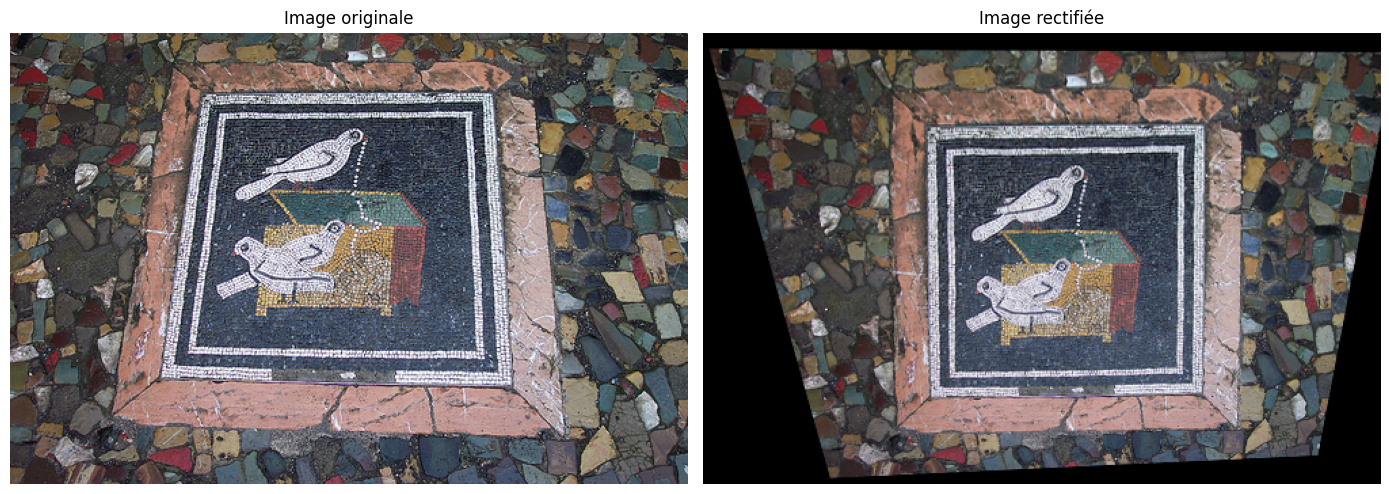

In [47]:
img_original = cv2.imread(PATH_IMG + "Pompei.jpg")
img_warp = cv2.warpPerspective(img_original, H, (w, h))

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image originale")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_warp, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image rectifiée")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Partie 3 : Création de panorama

## Q4 : Création de panorama par correspondances

**Question:** Modifier le script fourni afin de saisir les points par paires entre deux images, de façon à réaliser un panorama. Quelle condition doit respecter la prise de vue entre les deux images ?

### Réponse (condition de prise de vue):

Les images doivent être prises depuis le même centre optique avec uniquement une rotation de la caméra (pas de translation). Cette condition garantit que la transformation entre les images est une homographie exacte. Si le photographe se déplace entre les prises de vue, des erreurs de parallaxe apparaîtront car la transformation ne sera plus une simple homographie.

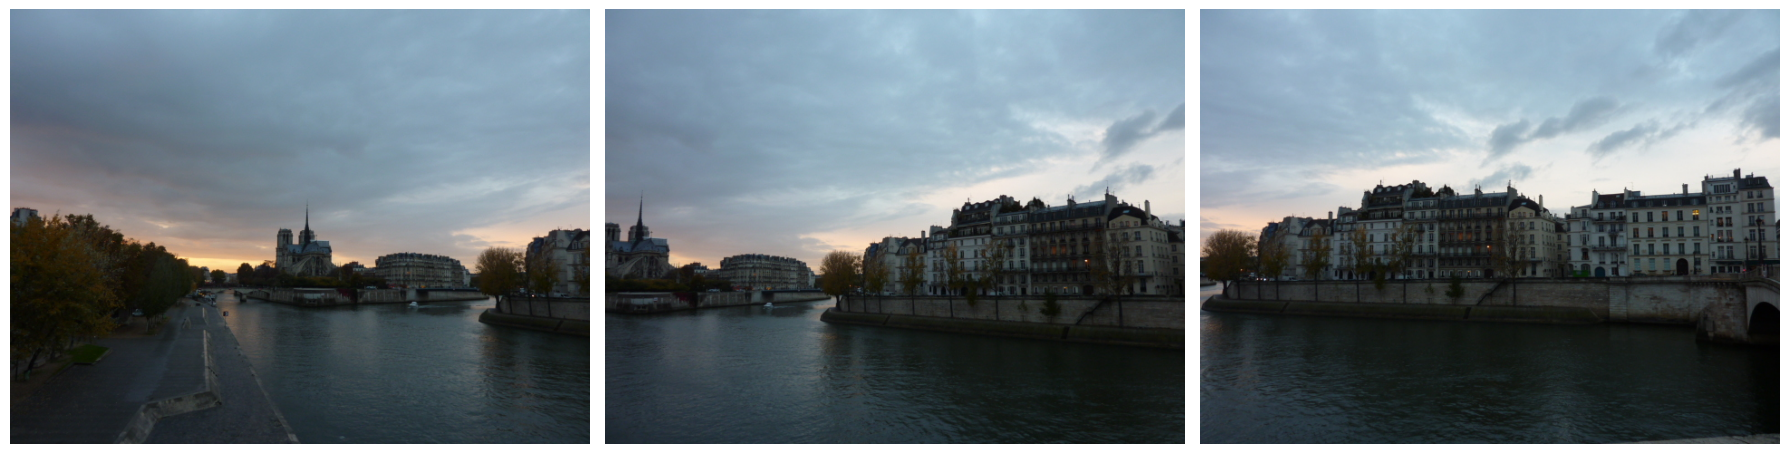

In [48]:
image_path = [PATH_IMG + "paris_a.jpg",
              PATH_IMG + "paris_b.jpg",
              PATH_IMG + "paris_c.jpg"]

def load_and_show_images():
    ret = []
    
    for path in image_path:
        img = cv2.imread(path)
        ret.append(img)
    
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, img in zip(axes, ret):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    return ret

images = load_and_show_images()

In [49]:
def select_point_pairs(img1, img2, window_name="Point Selection"):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h_max = max(h1, h2)
    
    combined = np.zeros((h_max, w1 + w2, 3), dtype=np.uint8)
    
    combined[:h1, :w1] = img1.copy()
    combined[:h2, w1:w1+w2] = img2.copy()
    
    cv2.line(combined, (w1, 0), (w1, h_max), (255, 255, 255), 2)
    clone = combined.copy()
    points1 = []
    points2 = []
    current_point = None
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal combined, clone, points1, points2, current_point
        
        if event == cv2.EVENT_LBUTTONDOWN:
            if x < w1:  # Click in image 1
                if current_point is None:
                    # First point of pair
                    current_point = (x, y)
                    cv2.circle(combined, (x, y), 5, (0, 255, 0), -1)
                    cv2.putText(combined, str(len(points1)+1), (x+10, y), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                else:
                    # Already have a point in img1, replace it
                    current_point = (x, y)
                    combined = clone.copy()
                    # Redraw all previous pairs
                    for i, (p1, p2) in enumerate(zip(points1, points2)):
                        cv2.circle(combined, (int(p1[0]), int(p1[1])), 5, (0, 255, 0), -1)
                        cv2.circle(combined, (int(p2[0]) + w1, int(p2[1])), 5, (0, 0, 255), -1)
                        cv2.putText(combined, str(i+1), (int(p1[0])+10, int(p1[1])), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        cv2.putText(combined, str(i+1), (int(p2[0])+w1+10, int(p2[1])), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                    cv2.line(combined, (w1, 0), (w1, h_max), (255, 255, 255), 2)
                    # Draw current point
                    cv2.circle(combined, (x, y), 5, (0, 255, 0), -1)
                    cv2.putText(combined, str(len(points1)+1), (x+10, y), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:  # Click in image 2
                if current_point is not None:
                    # Complete the pair
                    x2 = x - w1  # Adjust for combined image offset
                    points1.append([current_point[0], current_point[1]])
                    points2.append([x2, y])
                    
                    cv2.circle(combined, (x, y), 5, (0, 0, 255), -1)
                    cv2.putText(combined, str(len(points2)), (x+10, y), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                    
                    clone = combined.copy()
                    current_point = None
                    print(f"Pair {len(points1)}: ({points1[-1]}) <-> ({points2[-1]})")
                    
        elif event == cv2.EVENT_RBUTTONDOWN:
            # Reset all points
            points1.clear()
            points2.clear()
            current_point = None
            combined = np.zeros((h_max, w1 + w2, 3), dtype=np.uint8)
            combined[:h1, :w1] = img1.copy()
            combined[:h2, w1:w1+w2] = img2.copy()
            cv2.line(combined, (w1, 0), (w1, h_max), (255, 255, 255), 2)
            clone = combined.copy()
            print("Points reset")
    
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    while True:
        cv2.imshow(window_name, combined)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') and len(points1) >= 4:
            break
    
    cv2.destroyAllWindows()
    
    return np.array(points1, dtype=np.float32), np.array(points2, dtype=np.float32)

In [50]:
def create_panorama_center_reference(img_left, img_center, img_right, H_left_to_center, H_right_to_center):
    h_c, w_c = img_center.shape[:2]
    h_l, w_l = img_left.shape[:2]
    h_r, w_r = img_right.shape[:2]
    
    corners_left = np.array([
        [0, 0], [w_l, 0], [w_l, h_l], [0, h_l]
    ], dtype=np.float32).reshape(-1, 1, 2)
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H_left_to_center)
    
    corners_right = np.array([
        [0, 0], [w_r, 0], [w_r, h_r], [0, h_r]
    ], dtype=np.float32).reshape(-1, 1, 2)
    corners_right_transformed = cv2.perspectiveTransform(corners_right, H_right_to_center)
    
    corners_center = np.array([
        [0, 0], [w_c, 0], [w_c, h_c], [0, h_c]
    ], dtype=np.float32).reshape(-1, 1, 2)
    
    all_corners = np.concatenate([corners_left_transformed, corners_center, corners_right_transformed], axis=0)
    x_min, y_min = np.floor(all_corners.min(axis=0).flatten()).astype(int)
    x_max, y_max = np.ceil(all_corners.max(axis=0).flatten()).astype(int)
    
    translation = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ], dtype=np.float64)
    
    output_width = x_max - x_min
    output_height = y_max - y_min
    
    H_left_translated = translation @ H_left_to_center
    warped_left = cv2.warpPerspective(img_left, H_left_translated, (output_width, output_height))
    
    H_right_translated = translation @ H_right_to_center
    warped_right = cv2.warpPerspective(img_right, H_right_translated, (output_width, output_height))
    
    panorama = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    
    mask_left = (warped_left > 0)
    panorama[mask_left] = warped_left[mask_left]
    
    mask_right = (warped_right > 0)
    overlap_right = mask_right & (panorama > 0)
    panorama[mask_right & ~overlap_right[:,:,0:1].repeat(3, axis=2)] = warped_right[mask_right & ~overlap_right[:,:,0:1].repeat(3, axis=2)]
    panorama[overlap_right] = ((panorama[overlap_right].astype(np.float32) + 
                                 warped_right[overlap_right].astype(np.float32)) / 2).astype(np.uint8)
    
    x_offset = -x_min
    y_offset = -y_min
    
    center_region = panorama[y_offset:y_offset+h_c, x_offset:x_offset+w_c]
    mask_center = (img_center > 0)
    
    overlap_center = mask_center & (center_region > 0)
    center_region[mask_center & ~overlap_center] = img_center[mask_center & ~overlap_center]
    center_region[overlap_center] = ((center_region[overlap_center].astype(np.float32) + img_center[overlap_center].astype(np.float32)) / 2).astype(np.uint8)
    panorama[y_offset:y_offset+h_c, x_offset:x_offset+w_c] = center_region
    
    return panorama

pts_left, pts_center_from_left = select_point_pairs(images[0], images[1], "Select pairs: Left -> Center")

Pair 1: ([327, 209]) <-> ([41, 200])
Pair 2: ([351, 255]) <-> ([68, 253])
Pair 3: ([552, 335]) <-> ([269, 333])
Pair 4: ([595, 339]) <-> ([303, 335])
Pair 5: ([601, 355]) <-> ([307, 349])
Pair 6: ([439, 291]) <-> ([165, 292])
Pair 7: ([445, 325]) <-> ([180, 327])
Pair 8: ([604, 245]) <-> ([314, 253])
Pair 9: ([338, 249]) <-> ([51, 246])
Pair 10: ([455, 306]) <-> ([180, 308])


In [51]:
print(f"\nSelected {len(pts_left)} point pairs")

H_left_to_center = estimate_homography(pts_left, pts_center_from_left)
print("\nHomography H_left_to_center (maps image 0 -> image 1):")
print(H_left_to_center)


Selected 10 point pairs
[9.74043266 6.8091351  4.75912907 3.28668721 2.4406134  1.95475569
 1.66619372 0.73655548 0.07011152]

Homography H_left_to_center (maps image 0 -> image 1):
[[ 2.22379872e+00  5.71984893e-02 -6.75066398e+02]
 [ 5.27612876e-01  2.02686248e+00 -2.64061365e+02]
 [ 1.79126111e-03  3.94373246e-04  1.00000000e+00]]


In [52]:
# Step 3: Select matching points between images[2] (right) and images[1] (center)
print("=== Step 3: Select matching points between Image 2 (RIGHT) and Image 1 (CENTER) ===")
print("Click on RIGHT image first, then click corresponding point on CENTER image")
print("Press 'q' when done (minimum 4 pairs)")

pts_right, pts_center_from_right = select_point_pairs(images[2], images[1], "Select pairs: Right -> Center")

=== Step 3: Select matching points between Image 2 (RIGHT) and Image 1 (CENTER) ===
Click on RIGHT image first, then click corresponding point on CENTER image
Press 'q' when done (minimum 4 pairs)
Pair 1: ([27, 317]) <-> ([257, 330])
Pair 2: ([42, 319]) <-> ([269, 333])
Pair 3: ([65, 319]) <-> ([287, 334])
Pair 4: ([128, 321]) <-> ([340, 336])
Pair 5: ([144, 223]) <-> ([351, 245])
Pair 6: ([306, 326]) <-> ([520, 346])
Pair 7: ([335, 299]) <-> ([552, 316])
Pair 8: ([347, 326]) <-> ([569, 349])
Pair 9: ([375, 206]) <-> ([598, 211])
Pair 10: ([392, 225]) <-> ([620, 233])
Pair 11: ([287, 250]) <-> ([494, 267])
Pair 12: ([317, 261]) <-> ([530, 277])


In [53]:
print(f"\nSelected {len(pts_right)} point pairs")

H_right_to_center = estimate_homography(pts_right, pts_center_from_right)
print("\nHomography H_right_to_center (maps image 2 -> image 1):")
print(H_right_to_center)


Selected 12 point pairs
[9.49589073 6.82318443 4.9658842  3.54034847 2.22713179 1.80660128
 1.39761146 1.15513218 0.02141683]

Homography H_right_to_center (maps image 2 -> image 1):
[[ 5.61122421e-01  7.30969242e-03  2.30309525e+02]
 [-2.02192398e-01  8.18719353e-01  6.45209103e+01]
 [-6.59284723e-04 -6.12668057e-05  1.00000000e+00]]


Final panorama size: (864, 1757, 3)


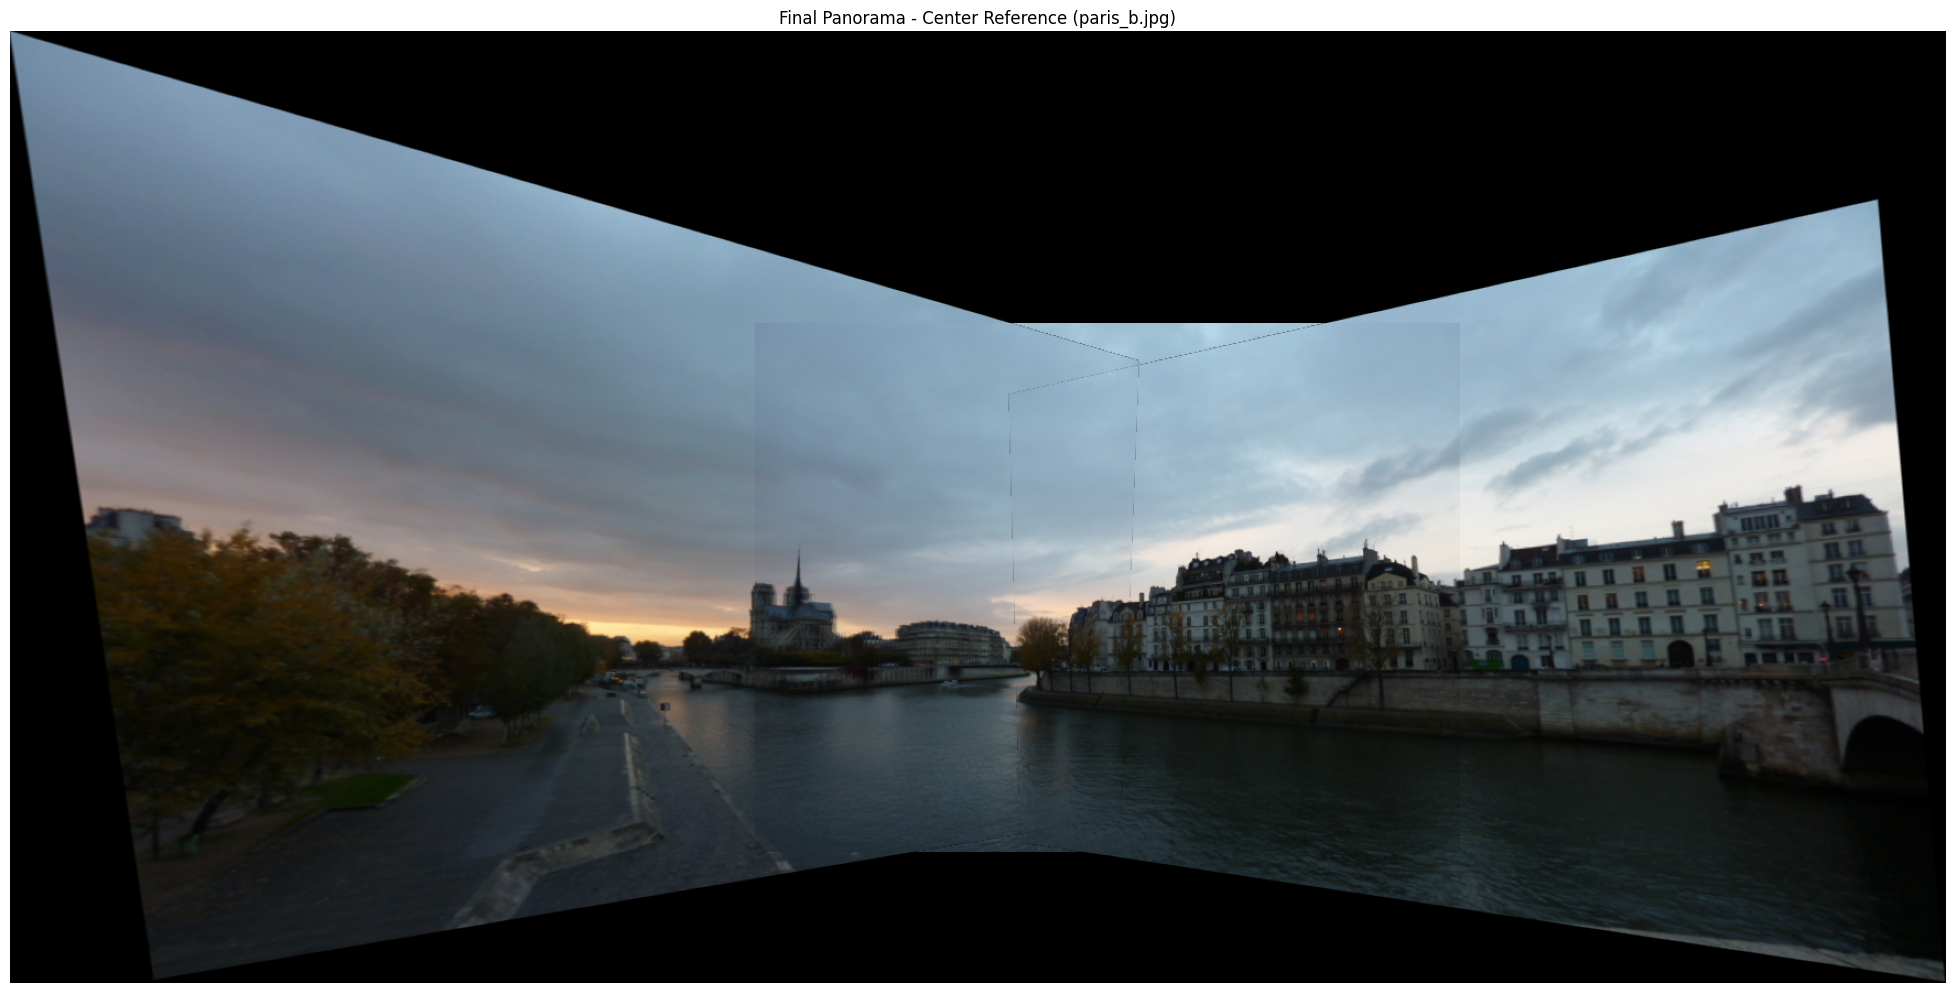

In [54]:
panorama_final = create_panorama_center_reference(
    images[0],  # left
    images[1],  # center (reference)
    images[2],  # right
    H_left_to_center,
    H_right_to_center
)

print(f"Final panorama size: {panorama_final.shape}")

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama_final, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama - Center Reference (paris_b.jpg)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [55]:
cv2.imwrite(PATH_IMG + "panorama_final.jpg", panorama_final)
print(f"Panorama saved to: {PATH_IMG}panorama_final.jpg")

Panorama saved to: ./Images_Homographie/panorama_final.jpg


## Q5 : Paramètres de la transformation

**Question:** Comment retrouver les paramètres de cette transformation à partir de ceux de l'homographie ?

### Réponse:

L'homographie H peut être décomposée pour extraire les paramètres de la transformation. Dans le cas général (scène planaire), on a:

$$H = K \cdot (R + \frac{t \cdot n^T}{d}) \cdot K^{-1}$$

Où:
- **K** = matrice des paramètres intrinsèques de la caméra
- **R** = matrice de rotation 3×3
- **t** = vecteur de translation
- **n** = normale du plan
- **d** = distance au plan

### Cas de rotation pure (panorama)

Dans le cas d'une rotation pure (comme pour un panorama), **t = 0**, ce qui simplifie à:

$$H = K \cdot R \cdot K^{-1}$$

Dans ce cas, il est possible d'estimer K par **auto-calibration** à partir de plusieurs homographies. En supposant des pixels carrés et pas de skew, K a la forme:

$$K = \begin{bmatrix} f & 0 & c_x \\ 0 & f & c_y \\ 0 & 0 & 1 \end{bmatrix}$$

La contrainte $H = K R K^{-1}$ implique que $H^{-T} \omega H^{-1} = \omega$, où $\omega = K^{-T} K^{-1}$ est l'image de la conique absolue (IAC). Avec **2 homographies ou plus**, on peut résoudre pour $\omega$ et ensuite extraire K par décomposition de Cholesky.

Une fois K connu, on peut extraire la rotation:
$$R = K^{-1} \cdot H \cdot K$$

## Q6 : Uniformisation des couleurs

**Question:** Proposer une stratégie d'uniformisation des couleurs entre les deux images visant à éviter les défauts photométriques à la jonction entre les deux images.

### Réponse:

On peut faire du histogram matching, ça veut dire : ajuster l'histogramme d'une image pour correspondre à celui de l'image de référence.